In [1]:
# ls

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('wave1_gluc_dummies_v2.csv', header=0, na_values=' ', index_col=0)
data.head()

,H1GI20,H1DA8,H1DA9,H1DA10,H1GH1,H1GH28,H1GH42,H1GH44,H1GH46,H1GH59A,...,BST90P13_3,BST90P24_1,BST90P24_2,BST90P24_3,BST90P24_4,BST90P24_5,BST90P24_6,BST90P26_1,BST90P26_2,BST90P26_3
AID,,,,,,,,,,,,,,,,,,,,,
57101310,11,33,4.0,0,4,5,4,5,5,6,...,0,0,0,0,0,0,1,0,0,1
57103869,12,24,6.0,7,4,2,4,4,5,6,...,1,0,1,0,0,0,0,0,1,0
57109625,8,14,7.0,3,1,2,2,4,4,5,...,0,0,1,0,0,0,0,0,0,1
57111071,8,35,12.0,2,2,4,3,3,3,5,...,0,0,1,0,0,0,0,0,0,1
57113943,9,10,5.0,4,3,4,3,4,5,6,...,1,0,1,0,0,0,0,1,0,0


In [4]:
data.shape

(5107, 504)

In [5]:
data.C_JOINT.value_counts()

0    4746
1     361
Name: C_JOINT, dtype: int64

#### Create CV Labels

In [6]:
data['cv_label'] = data.index

In [7]:
data.shape

(5107, 505)

In [8]:
# data.head()

In [9]:
target = data.C_JOINT
target.head()

AID
57101310    1
57103869    0
57109625    0
57111071    0
57113943    0
Name: C_JOINT, dtype: int64

In [10]:
del data['C_JOINT']

#### Oversample to balance classes

In [11]:
# NB: If you use this you'll need to add the package first
# conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [12]:
ros = RandomOverSampler(random_state=7)

In [13]:
data_res, target_res = ros.fit_sample(data, target)

In [14]:
data_res.shape

(9492, 504)

In [15]:
target_res.shape

(9492,)

In [16]:
# Double check to make sure class counts have been balanced
unique, counts = np.unique(target_res, return_counts=True)
dict(zip(unique, counts))

{0: 4746, 1: 4746}

#### Create training and testing sets

In [17]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_res, target_res, test_size=0.2, random_state=7)#, stratify=target_res)

/Users/davidscroggins/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
cv_labels_train = X_train[:,[503]]
cv_labels_test = X_test[:,[503]]

In [19]:
X_train = np.delete(X_train, -1, 1)
X_test = np.delete(X_test, -1, 1)

In [20]:
# data_res[:,[503]]

In [21]:
# cv_labels = data_res[:,[503]] #Create array of cv_labels

In [22]:
# cv_labels

In [23]:
# data_res = np.delete(data_res, -1, 1) #Delete cv_labels from data array

In [24]:
# data_res.shape

In [25]:
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import cross_val_predict

#### Cross-Validate predictions on new dataset

In [26]:
lkf_train = LabelKFold(cv_labels_train, n_folds=10)
lkf_test = LabelKFold(cv_labels_test, n_folds=10)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [28]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [29]:
predicted = cross_val_predict(rfclf, X_train, y_train, cv=lkf_train)

In [30]:
print(classification_report(y_train, predicted))

             precision    recall  f1-score   support

          0       0.54      0.74      0.62      3793
          1       0.59      0.38      0.46      3800

avg / total       0.57      0.56      0.54      7593



#### Use GridSearchCV to tune parameters

In [31]:
# from sklearn.model_selection import GridSearchCV

In [32]:
# rfGridSearch = RandomForestClassifier()

In [33]:
# np.arange(10, 101, 20)

In [34]:
# parameters = {
#     'criterion' : ['entropy', 'gini'],
#     'max_depth' : np.arange(1, 11, 3),
#     'min_samples_leaf' : np.arange(1, 102, 20),
#     'min_samples_split' : np.arange(2, 103, 20),
#     "n_estimators" : np.arange(10, 101, 20)
# }

In [35]:
# gs = GridSearchCV(rfGridSearch, parameters, verbose=1, cv=lkf_train, n_jobs=-1, scoring='recall')

In [36]:
# %time _ = gs.fit(X_train, y_train)

In [37]:
# gs.best_params_

#### Test best parameters

In [38]:
# Ten-fold, default scoring
rfclf2 = RandomForestClassifier(criterion='gini', max_depth=1,
                                min_samples_leaf=1, min_samples_split=82,
                                n_estimators=30)

In [39]:
# # Five-fold, scoring recall
# rfclf2 = RandomForestClassifier(criterion='entropy', max_depth=5,
#                                 min_samples_leaf=91, min_samples_split=72,
#                                 n_estimators=9)

In [40]:
rfclf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=82, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [41]:
# Repeat cross-validated testing
predicted2 = cross_val_predict(rfclf2, X_test, y_test, cv=lkf_test)

In [42]:
print(classification_report(y_test, predicted2))

             precision    recall  f1-score   support

          0       0.59      0.65      0.62       953
          1       0.61      0.54      0.57       946

avg / total       0.60      0.60      0.59      1899



In [43]:
cd graphics

/Users/davidscroggins/Google Drive/DePaul/csc478_machineLearning/csc478_project/csc478_initialModels/graphics


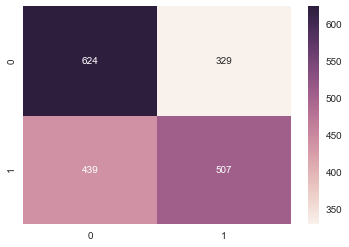

In [44]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
cm = confusion_matrix(y_test, predicted2)
hm = sb.heatmap(cm, annot=True, fmt="d")
fig = hm.get_figure()
fig.savefig("heatMap_oversampling_gluc_randomForest2")

In [45]:
importances = rfclf2.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = list(data)
top_indices = indices[:15]
for i in top_indices:
    print features_list[i]

H1GI6A_1
H1GI6A_0
H1GH8_4
BST90P23
BST90P02_2
BST90P15
H1GI6B_0
BST90P29
H1RE1_22
H1RE1_4
H1NM8
H1NM2_0
BST90P02_1
H1GI6B_1
BST90P18
